## sandbox workspace for function training 



In [1]:
# block to import everything we could possibly need. 
import pysofaconventions as sofa
import soundfile as sf
import numpy as np
import os
import glob
from scipy.io import wavfile
import importlib
import matplotlib.pyplot as plt
import data_preprocessing; importlib.reload(data_preprocessing); import data_preprocessing
import feature_extract; importlib.reload(feature_extract); import feature_extract
import viz; importlib.reload(viz); import viz
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import butter, filtfilt
import re
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau






Recording stats:
  Sample rate: 44100 Hz
  Length: 6.15 seconds
  Bit depth: int16
  Left peak: 18672
  Right peak: 17840
  Clipping samples (left): 0
  Clipping samples (right): 0
  SNR estimate (left): 1.9 dB


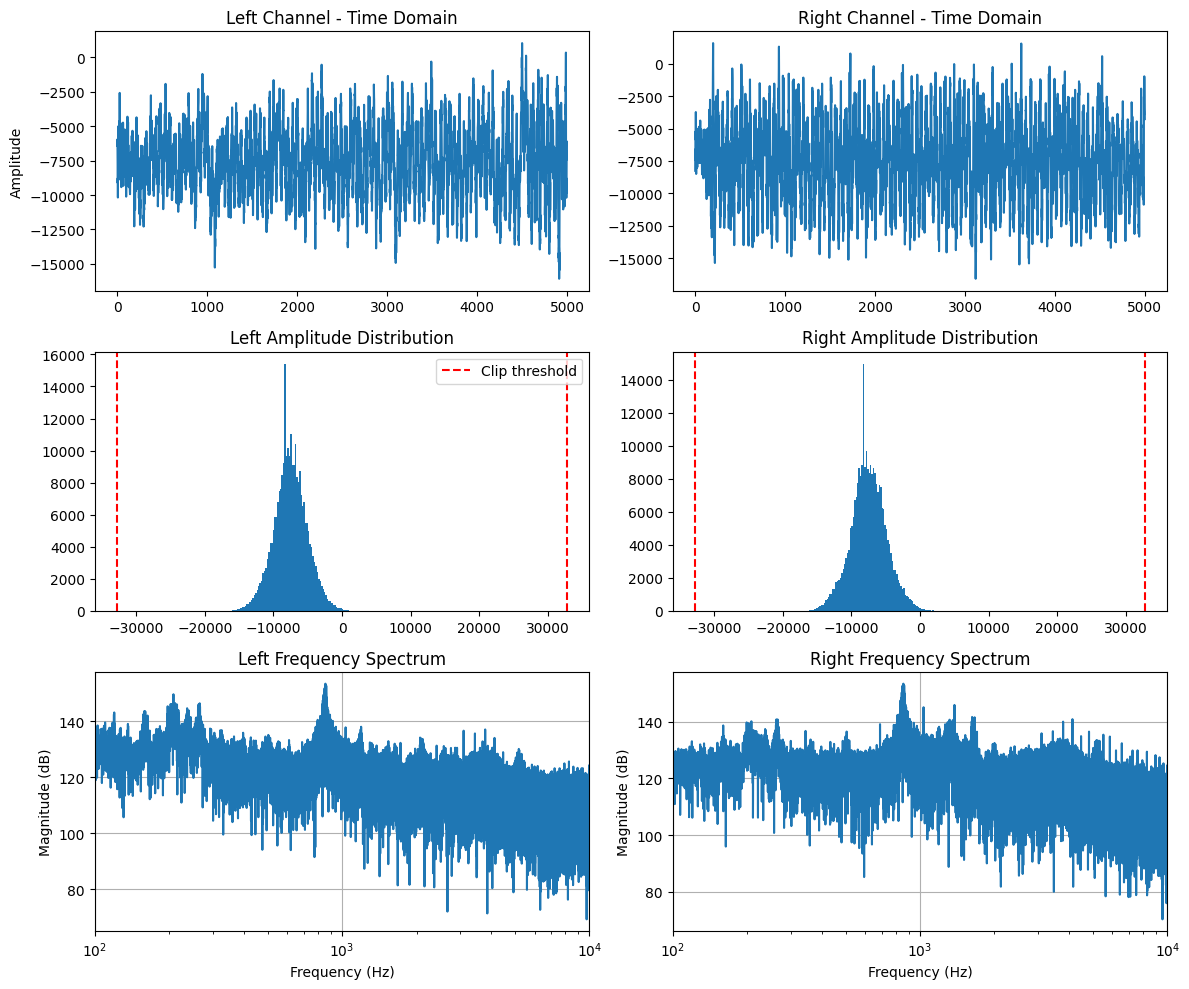

In [70]:
import matplotlib.pyplot as plt
from scipy.io import wavfile

# Pick one file
test_file = "/Users/alexdhawan/Desktop/ECE5730/ML-head-transfer-functions/python_training/data/training_audio/raw/train_set/sine_16_8_1.wav"
fs, data = wavfile.read(test_file)

left = data[:, 0]
right = data[:, 1]

fig, axes = plt.subplots(3, 2, figsize=(12, 10))

# Time domain
axes[0, 0].plot(left[:5000])
axes[0, 0].set_title('Left Channel - Time Domain')
axes[0, 0].set_ylabel('Amplitude')

axes[0, 1].plot(right[:5000])
axes[0, 1].set_title('Right Channel - Time Domain')

# Check for clipping
left_norm = left / np.max(np.abs(left))
right_norm = right / np.max(np.abs(right))
axes[1, 0].hist(left, bins=100)
axes[1, 0].set_title('Left Amplitude Distribution')
axes[1, 0].axvline(x=32767, color='r', linestyle='--', label='Clip threshold')
axes[1, 0].axvline(x=-32768, color='r', linestyle='--')
axes[1, 0].legend()

axes[1, 1].hist(right, bins=100)
axes[1, 1].set_title('Right Amplitude Distribution')
axes[1, 1].axvline(x=32767, color='r', linestyle='--')
axes[1, 1].axvline(x=-32768, color='r', linestyle='--')

# Frequency domain
from scipy.fft import rfft, rfftfreq
L_fft = np.abs(rfft(left))
R_fft = np.abs(rfft(right))
freqs = rfftfreq(len(left), 1/fs)

axes[2, 0].semilogx(freqs[1:len(freqs)//2], 20*np.log10(L_fft[1:len(L_fft)//2] + 1e-10))
axes[2, 0].set_title('Left Frequency Spectrum')
axes[2, 0].set_xlabel('Frequency (Hz)')
axes[2, 0].set_ylabel('Magnitude (dB)')
axes[2, 0].grid(True)
axes[2, 0].set_xlim([100, 10000])

axes[2, 1].semilogx(freqs[1:len(freqs)//2], 20*np.log10(R_fft[1:len(R_fft)//2] + 1e-10))
axes[2, 1].set_title('Right Frequency Spectrum')
axes[2, 1].set_xlabel('Frequency (Hz)')
axes[2, 1].set_ylabel('Magnitude (dB)')
axes[2, 1].grid(True)
axes[2, 1].set_xlim([100, 10000])

plt.tight_layout()
plt.savefig('recording_quality_check.png', dpi=150)
print(f"\nRecording stats:")
print(f"  Sample rate: {fs} Hz")
print(f"  Length: {len(left)/fs:.2f} seconds")
print(f"  Bit depth: {data.dtype}")
print(f"  Left peak: {np.max(np.abs(left))}")
print(f"  Right peak: {np.max(np.abs(right))}")
print(f"  Clipping samples (left): {np.sum(np.abs(left) >= 32767)}")
print(f"  Clipping samples (right): {np.sum(np.abs(right) >= 32767)}")
print(f"  SNR estimate (left): {20*np.log10(np.std(left) / (np.std(left[:1000]) + 1e-10)):.1f} dB")

plt.show()

Found 514 files. Parsing...
Augmenting...
Training on 3948 samples.


/Users/alexdhawan/Desktop/ECE5730/ML-head-transfer-functions/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/alexdhawan/Desktop/ECE5730/ML-head-transfer-functions/.venv/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 30s 232ms/step - loss: 0.9669 - mae: 1.3605 - val_loss: 0.2461 - val_mae: 0.6405 - learning_rate: 5.0000e-04
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 29s 235ms/step - loss: 0.2784 - mae: 0.6374 - val_loss: 0.2472 - val_mae: 0.6435 - learning_rate: 5.0000e-04
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 30s 243ms/step - loss: 0.2529 - mae: 0.6054 - val_loss: 0.2309 - val_mae: 0.5931 - learning_rate: 5.0000e-04
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 36s 287ms/step - loss: 0.2355 - mae: 0.5807 - val_loss: 0.2262 - val_mae: 0.5905 - learning_rate: 5.0000e-04
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 42s 342ms/step - loss: 0.2266 - mae: 0.5718 - val_loss: 0.1714 - val_mae: 0.4982 - learning_rate: 5.0000e-04
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 43s 343ms/step - loss: 0.2108 - mae: 0.5497 - val_loss: 0.1734 - val_mae: 0.4989 - learning_rate: 5.0000e-04
Epoch 7/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 40s 319ms/step - loss: 0.1993 - mae: 0.5365 - val_loss: 0.1585 - v

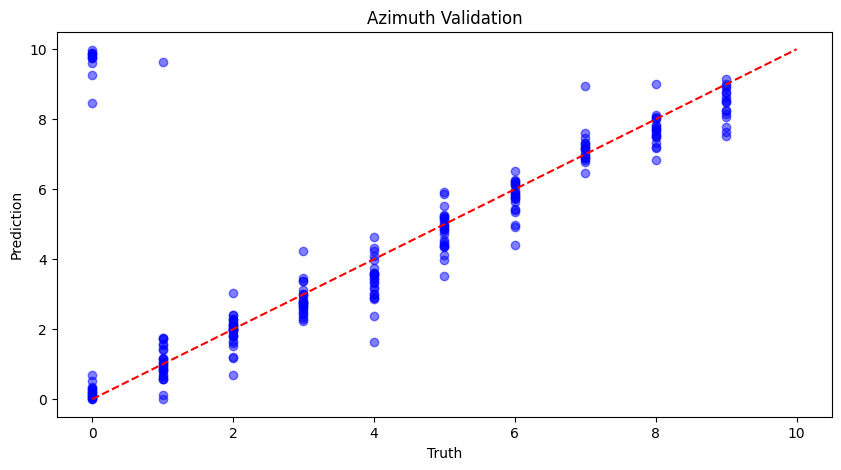

In [44]:
import os
import glob
import re
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
SAMPLE_RATE = 44100
DATA_DIR = "/Users/alexdhawan/Desktop/ECE5730/ML-head-transfer-functions/python_training/data/training_audio/raw/train_set"
CHUNK_DURATION_MS = 1100  
N_MELS = 96               
SILENCE_THRESHOLD = 0.01 
AZIMUTH_STEPS = 10        
ELEVATION_STEPS = 10      

# --- 1. AUDIO SLICER (Proven Working) ---
class AudioSlicer:
    def __init__(self, sample_rate, chunk_ms, n_mels, silence_thresh):
        self.sr = sample_rate
        self.chunk_len = int(sample_rate * (chunk_ms / 1000))
        self.n_mels = n_mels
        self.n_fft = 4096
        self.hop_length = 256 
        self.silence_thresh = silence_thresh

    def process_and_split(self, filepath, label):
        try:
            audio, _ = librosa.load(filepath, sr=self.sr, mono=False)
        except Exception:
            return [], [], [], []
            
        if audio.ndim != 2 or audio.shape[0] != 2: return [], [], [], []
        audio = audio.T 
        
        # DC Bias Fix
        audio -= np.mean(audio, axis=0)
        
        total_samples = len(audio)
        num_chunks = total_samples // self.chunk_len
        
        X_train_local, y_train_local = [], []
        X_test_local, y_test_local = [], []

        for i in range(num_chunks):
            start = i * self.chunk_len
            end = start + self.chunk_len
            segment = audio[start:end, :]
            
            rms = np.sqrt(np.mean(segment**2))
            if rms < self.silence_thresh: continue 

            specs = []
            for ch in range(2): 
                S = librosa.feature.melspectrogram(
                    y=segment[:, ch], sr=self.sr, n_fft=self.n_fft, 
                    hop_length=self.hop_length, n_mels=self.n_mels
                )
                S_db = librosa.power_to_db(S, ref=np.max)
                S_norm = (np.maximum(S_db, -80) + 80) / 80
                specs.append(S_norm.T) 
            
            spec_diff = specs[0] - specs[1]
            spec_diff = np.clip(spec_diff, -1.0, 1.0)
            
            spec_final = np.stack([specs[0], specs[1], spec_diff], axis=-1)
            
            # Simple 80/20 Split
            if (i % 5) == 4: 
                X_test_local.append(spec_final)
                y_test_local.append(label)
            else:
                X_train_local.append(spec_final)
                y_train_local.append(label)
                
        return X_train_local, y_train_local, X_test_local, y_test_local

# --- 2. DATA LOADING ---
def load_and_split_dataset(data_dir):
    slicer = AudioSlicer(SAMPLE_RATE, CHUNK_DURATION_MS, N_MELS, SILENCE_THRESHOLD)
    files = glob.glob(os.path.join(data_dir, "*.wav"))
    
    X_train_all, y_train_all = [], []
    X_test_all, y_test_all = [], []
    
    # Relaxed Regex to include "copy" files
    pattern = re.compile(r'_(\d+)_(\d+)(?:.*)?\.wav$')
    
    print(f"Found {len(files)} files. Parsing...")
    
    for f in files:
        match = pattern.search(f)
        if match:
            elev_idx = float(match.group(1))
            az_idx = float(match.group(2))
            
            elev_theta = (elev_idx / ELEVATION_STEPS) * (2 * np.pi)
            az_theta = (az_idx / AZIMUTH_STEPS) * (2 * np.pi)
            
            label_vector = [
                np.sin(elev_theta), np.cos(elev_theta), 
                np.sin(az_theta), np.cos(az_theta)
            ] 
            
            Xt, yt, Xv, yv = slicer.process_and_split(f, label_vector)
            X_train_all.extend(Xt); y_train_all.extend(yt)
            X_test_all.extend(Xv); y_test_all.extend(yv)
            
    return (np.array(X_train_all), np.array(y_train_all), 
            np.array(X_test_all), np.array(y_test_all))

# --- 3. THE "SCALED-UP SANITY" MODEL ---
def create_production_model(input_shape):
    model = models.Sequential()
    
    # Block 1
    model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization()) # Added for stability
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Block 2
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 3 (New Depth)
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    
    # Dense Block
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.3)) # Prevent "Piano Kid" memorization
    
    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.3))

    # Output
    model.add(layers.Dense(4, activation='linear')) 
    
    return model

# --- 4. UTILS ---
def decode_predictions(preds):
    decoded = []
    for p in preds:
        e_sin, e_cos, az_sin, az_cos = p
        e_angle = np.arctan2(e_sin, e_cos)
        az_angle = np.arctan2(az_sin, az_cos)
        
        # Convert to 0-2PI
        if e_angle < 0: e_angle += 2*np.pi
        if az_angle < 0: az_angle += 2*np.pi
        
        # Scale to indices
        e_idx = (e_angle / (2*np.pi)) * ELEVATION_STEPS
        az_idx = (az_angle / (2*np.pi)) * AZIMUTH_STEPS
        decoded.append([e_idx, az_idx])
    return np.array(decoded)

def augment_data(X_data):
    X_aug = X_data.copy()
    gain_factor = np.random.uniform(0.7, 1.3, size=(X_aug.shape[0], 1, 1, 1))
    X_aug *= gain_factor
    X_aug = np.clip(X_aug, 0.0, 1.0) 
    return X_aug

# --- MAIN ---
if __name__ == "__main__":
    X_train, y_train, X_test, y_test = load_and_split_dataset(DATA_DIR)
    
    if len(X_train) == 0:
        print("No data found!")
    else:
        # Shuffle immediately
        indices = np.arange(len(X_train))
        np.random.shuffle(indices)
        X_train = X_train[indices]
        y_train = y_train[indices]

        # Augment
        print("Augmenting...")
        X_train_aug = augment_data(X_train)
        X_final = np.concatenate([X_train, X_train_aug], axis=0)
        y_final = np.concatenate([y_train, y_train], axis=0)
        
        print(f"Training on {len(X_final)} samples.")
        
        model = create_production_model(X_final[0].shape)
        
        # Optimizer & Huber Loss
        optimizer = optimizers.Adam(learning_rate=0.0005) # Slower LR for stability
        robust_loss = tf.keras.losses.Huber(delta=1.0)
        
        model.compile(loss=robust_loss, optimizer=optimizer, metrics=['mae'])
        
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
        ]

        history = model.fit(
            X_final, y_final,
            validation_data=(X_test, y_test),
            epochs=50, 
            batch_size=32,
            callbacks=callbacks
        )
        
        # Visualization
        preds = model.predict(X_test)
        dec_preds = decode_predictions(preds)
        dec_truth = decode_predictions(y_test)
        
        plt.figure(figsize=(10, 5))
        plt.scatter(dec_truth[:, 1], dec_preds[:, 1], alpha=0.5, c='blue')
        plt.plot([0, AZIMUTH_STEPS], [0, AZIMUTH_STEPS], 'r--')
        plt.title('Azimuth Validation')
        plt.xlabel('Truth'); plt.ylabel('Prediction')
        plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


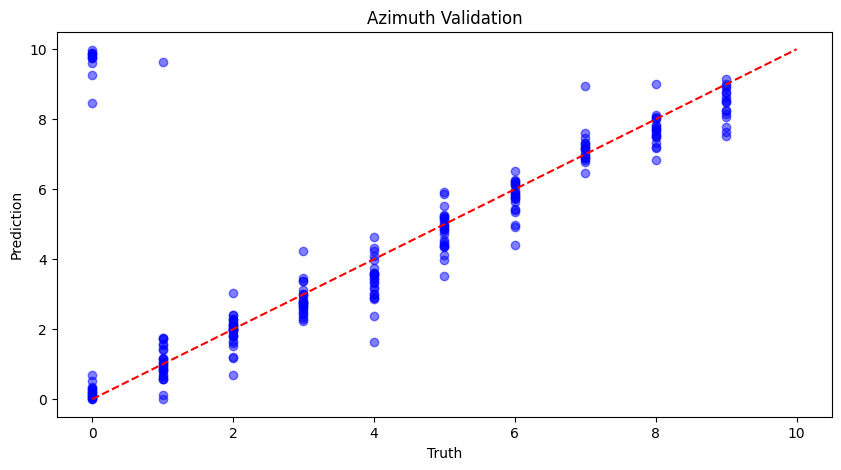

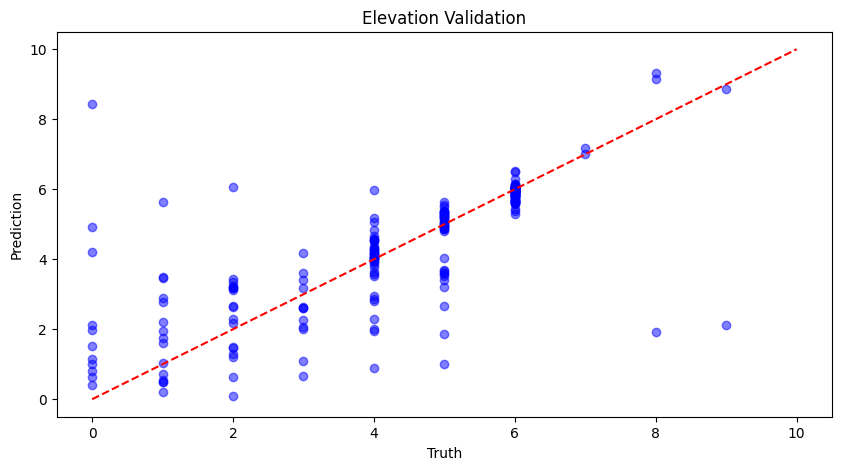

In [48]:
# Visualization
preds = model.predict(X_test)
dec_preds = decode_predictions(preds)
dec_truth = decode_predictions(y_test)

plt.figure(figsize=(10, 5))
plt.scatter(dec_truth[:, 1], dec_preds[:, 1], alpha=0.5, c='blue')
plt.plot([0, AZIMUTH_STEPS], [0, AZIMUTH_STEPS], 'r--')
plt.title('Azimuth Validation')
plt.xlabel('Truth'); plt.ylabel('Prediction')
plt.show()
plt.figure(figsize=(10, 5))
plt.scatter(dec_truth[:, 0], dec_preds[:, 0], alpha=0.5, c='blue')
plt.plot([0, ELEVATION_STEPS], [0, ELEVATION_STEPS], 'r--')
plt.title('Elevation Validation')
plt.xlabel('Truth'); plt.ylabel('Prediction')
plt.show()


In [49]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# --- CONFIGURATION ---
# Pico RAM is tiny (264KB). We aim for a model file size < 80KB.
# This requires DRASTIC parameter reduction.

def create_pico_model(input_shape):
    # USE 'Input' layer explicitly as requested by Keras warning
    inputs = layers.Input(shape=input_shape)
    
    # --- Block 1: The "Ears" (Spatial Features) ---
    # We use fewer filters (16) to save memory
    x = layers.Conv2D(16, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.1)(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # --- Block 2: The "Cortex" (Pattern Matching) ---
    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.1)(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # --- Block 3: The "Deep Thinker" ---
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.1)(x)
    # Note: We remove the last MaxPooling to keep some spatial grid info before pooling
    
    # --- THE MAGIC TRICK: Global Average Pooling ---
    # Instead of Flatten() which creates millions of connections,
    # we just take the average value of each of the 64 filters.
    # Output shape becomes (Batch, 64). 
    # Parameter cost: 0 bytes.
    x = layers.GlobalAveragePooling2D()(x)
    
    # --- Output Head (Tiny) ---
    x = layers.Dropout(0.2)(x) 
    x = layers.Dense(32)(x) # Small dense layer
    x = layers.LeakyReLU(negative_slope=0.1)(x)
    
    outputs = layers.Dense(4, activation='linear')(x) 
    
    model = models.Model(inputs=inputs, outputs=outputs, name="PicoLocator_v1")
    return model

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    # Assume X_final, y_final, X_test, y_test exist from previous run
    
    print("\n--- BUILDING PICO MODEL ---")
    pico_model = create_pico_model(X_final[0].shape)
    pico_model.summary() # LOOK AT THE "Total params". It should be tiny.
    
    # Compile
    pico_model.compile(
        loss=tf.keras.losses.Huber(delta=1.0),
        optimizer=optimizers.Adam(learning_rate=0.001), # Slightly higher LR for small model
        metrics=['mae']
    )
    
    # Train
    print("\n--- DISTILLING KNOWLEDGE ---")
    history = pico_model.fit(
        X_final, y_final,
        validation_data=(X_test, y_test),
        epochs=40, # Small models converge faster
        batch_size=32,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
        ]
    )
    
    # Save specifically for TFLite conversion
    pico_model.save('pico_locator.keras')
    print("✅ Pico Model Saved. Ready for TFLite conversion.")


--- BUILDING PICO MODEL ---


Model: "PicoLocator_v1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_36 (InputLayer)     │ (None, 190, 96, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_106 (Conv2D)             │ (None, 190, 96, 16)    │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_78          │ (None, 190, 96, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 190, 96, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_84 (MaxPooling2D) │ (None, 95, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 95, 48, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_79          │ (None, 95, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 95, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_85 (MaxPooling2D) │ (None, 47, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_108 (Conv2D)             │ (None, 47, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_80          │ (None, 47, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 47, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,244 (102.52 KB)

 Trainable params: 26,020 (101.64 KB)

 Non-trainable params: 224 (896.00 B)


--- DISTILLING KNOWLEDGE ---
Epoch 1/40
124/124 ━━━━━━━━━━━━━━━━━━━━ 14s 105ms/step - loss: 0.2355 - mae: 0.5954 - val_loss: 0.2879 - val_mae: 0.6764 - learning_rate: 0.0010
Epoch 2/40
124/124 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.2150 - mae: 0.5687 - val_loss: 0.2998 - val_mae: 0.6776 - learning_rate: 0.0010
Epoch 3/40
124/124 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.2048 - mae: 0.5512 - val_loss: 0.2607 - val_mae: 0.6379 - learning_rate: 0.0010
Epoch 4/40
124/124 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.1977 - mae: 0.5379 - val_loss: 0.2112 - val_mae: 0.5782 - learning_rate: 0.0010
Epoch 5/40
124/124 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.1951 - mae: 0.5333 - val_loss: 0.2055 - val_mae: 0.5354 - learning_rate: 0.0010
Epoch 6/40
124/124 ━━━━━━━━━━━━━━━━━━━━ 24s 195ms/step - loss: 0.1878 - mae: 0.5201 - val_loss: 0.1714 - val_mae: 0.4849 - learning_rate: 0.0010
Epoch 7/40
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 213ms/step - loss: 0.1854 - mae: 0.5155 - val_loss: 0.2827 -


--- Generating Predictions for Pico Model ---
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


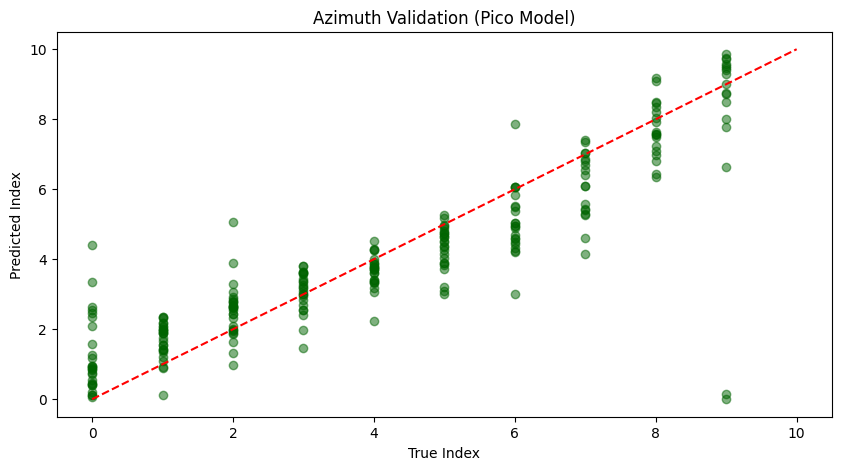

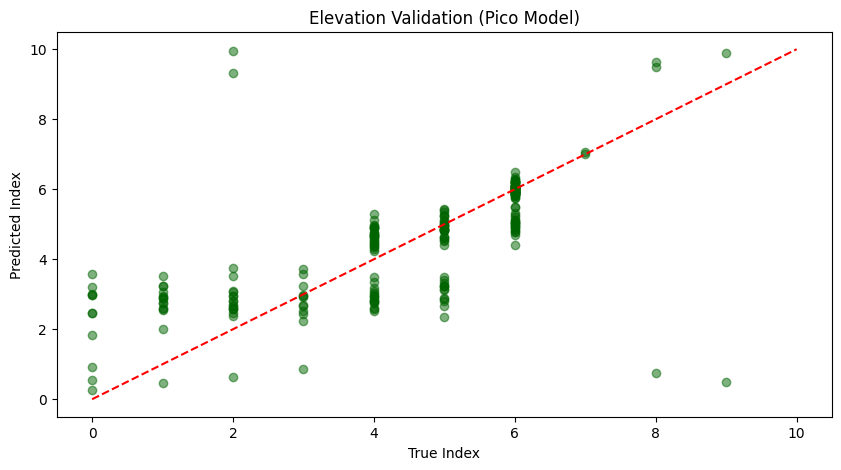

In [53]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# --- CONFIGURATION (Ensure these match your training script) ---
ELEVATION_STEPS = 10        
AZIMUTH_STEPS = 10      

# --- 1. UTILS (Place the following utility functions here) ---
# Assuming load_and_split_dataset, decode_predictions, X_test, y_test 
# are available or loaded from files.

def decode_predictions(preds, elev_steps=ELEVATION_STEPS, az_steps=AZIMUTH_STEPS):
    # This is your existing decode function
    decoded = []
    for p in preds:
        e_sin, e_cos, az_sin, az_cos = p
        
        def decode_trig(sin_val, cos_val, steps):
            angle = np.arctan2(sin_val, cos_val)
            if angle < 0: angle += 2 * np.pi
            return (angle / (2 * np.pi)) * steps
            
        e_idx = decode_trig(e_sin, e_cos, elev_steps)
        az_idx = decode_trig(az_sin, az_cos, az_steps)
        decoded.append([e_idx, az_idx])
    return np.array(decoded)


# --- 2. MAIN VISUALIZATION ---

# Load the saved Pico Model (ensure the file path is correct)
pico_model = tf.keras.models.load_model('pico_locator.keras')
model_big = tf.keras.models.load_model('binaural_model_v1.keras')
# Assuming X_test and y_test are still loaded in your environment from the main script.
# If not, you must reload your dataset here: X_train, y_train, X_test, y_test = load_and_split_dataset(DATA_DIR)

print("\n--- Generating Predictions for Pico Model ---")
preds_pico = pico_model.predict(X_test)
dec_preds_pico = decode_predictions(preds_pico)
dec_truth = decode_predictions(y_test) # True labels remain the same

# --- Azimuth Plot ---
plt.figure(figsize=(10, 5))
plt.scatter(dec_truth[:, 1], dec_preds_pico[:, 1], alpha=0.5, c='darkgreen', label='Pico Model Prediction')
plt.plot([0, AZIMUTH_STEPS], [0, AZIMUTH_STEPS], 'r--', label='Ideal')
plt.title('Azimuth Validation (Pico Model)')
plt.xlabel('True Index'); plt.ylabel('Predicted Index')
# plt.legend()
plt.show()

# --- Elevation Plot ---
plt.figure(figsize=(10, 5))
plt.scatter(dec_truth[:, 0], dec_preds_pico[:, 0], alpha=0.5, c='darkgreen', label='Pico Model Prediction')
plt.plot([0, ELEVATION_STEPS], [0, ELEVATION_STEPS], 'r--', label='Ideal')
plt.title('Elevation Validation (Pico Model)')
plt.xlabel('True Index'); plt.ylabel('Predicted Index')
# plt.legend()
plt.show()

In [59]:
import tensorflow as tf
import numpy as np
import os

# --- Configuration ---
# 1. Define the input Keras model file name
MODEL_NAME = 'pico_locator.keras'
# 2. Define the output TensorFlow Lite file name
TFLITE_MODEL_FILE = 'pico_locator_final.tflite'
# 3. Define the final C/C++ header file name
C_HEADER_FILE = 'model_data.h'

# 1. Load the Keras Model
if not os.path.exists(MODEL_NAME):
    print(f"Error: Keras model file '{MODEL_NAME}' not found. Did you save it?")
else:
    print(f"Loading Keras model: {MODEL_NAME}")
    model = tf.keras.models.load_model(MODEL_NAME)

    # 2. Instantiate the TFLite Converter
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    
    # --- OPTION 1: No Quantization (Good for testing) ---
    # We already used small floats (float32). We will convert to the TFLite version of float32.
    # converter.optimizations = [] # This is the default.

    # 3. Perform the conversion
    print("Converting model to TFLite...")
    tflite_model = converter.convert()

    # 4. Save the TFLite file
    with open(TFLITE_MODEL_FILE, 'wb') as f:
        f.write(tflite_model)
    
    # Check the size
    tflite_size_kb = os.path.getsize(TFLITE_MODEL_FILE) / 1024
    print(f"✅ TFLite model saved as '{TFLITE_MODEL_FILE}'.")
    print(f"File Size: {tflite_size_kb:.2f} KB")

    # 5. Convert to a C Header file (for Microcontrollers)
    # The Pico cannot load an external .tflite file, so we embed it as an array.
    
    # Format the array data
    byte_array = [format(b, '#04x') for b in tflite_model]
    
    # Create the C/C++ header content
    c_header_content = f"""// TFLite Model Data for Raspberry Pi Pico
// Model Name: {TFLITE_MODEL_FILE}
// Size: {len(byte_array)} bytes

const unsigned char g_model[] = {{
  {', '.join(byte_array)}
}};
const int g_model_len = {len(byte_array)};
"""
    
    with open(C_HEADER_FILE, 'w') as f:
        f.write(c_header_content)
        
    print(f"✅ C/C++ Header file saved as '{C_HEADER_FILE}'.")
    print("You can now include this header in your Pico project.")



Loading Keras model: pico_locator.keras
Converting model to TFLite...
INFO:tensorflow:Assets written to: /var/folders/1t/nfnkr6gx3wng0wv9bfmg46mc0000gn/T/tmp5fe2tt9f/assets


INFO:tensorflow:Assets written to: /var/folders/1t/nfnkr6gx3wng0wv9bfmg46mc0000gn/T/tmp5fe2tt9f/assets


Saved artifact at '/var/folders/1t/nfnkr6gx3wng0wv9bfmg46mc0000gn/T/tmp5fe2tt9f'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 190, 96, 3), dtype=tf.float32, name='input_layer_36')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  15319477584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15319778704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15319778512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15319786384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15319785808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15319778128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15319777552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15319783504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15319786192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15319782736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  153197833

W0000 00:00:1765399286.661555 5688214 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1765399286.661597 5688214 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.


✅ TFLite model saved as 'pico_locator_final.tflite'.
File Size: 105.86 KB
✅ C/C++ Header file saved as 'model_data.h'.
You can now include this header in your Pico project.


2025-12-10 15:41:26.663643: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/1t/nfnkr6gx3wng0wv9bfmg46mc0000gn/T/tmp5fe2tt9f
2025-12-10 15:41:26.665134: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-12-10 15:41:26.665150: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/1t/nfnkr6gx3wng0wv9bfmg46mc0000gn/T/tmp5fe2tt9f
I0000 00:00:1765399286.678440 5688214 mlir_graph_optimization_pass.cc:437] MLIR V1 optimization pass is not enabled
2025-12-10 15:41:26.681539: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-12-10 15:41:26.720743: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folders/1t/nfnkr6gx3wng0wv9bfmg46mc0000gn/T/tmp5fe2tt9f
2025-12-10 15:41:26.731015: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 67381 microsecond

In [67]:
# Re-run these three lines from your main script
X_train, y_train, X_test, y_test = load_and_split_dataset(DATA_DIR)

# Shuffle (critical for good calibration)
indices = np.arange(len(X_train))
np.random.shuffle(indices)
X_train = X_train[indices]

# NOTE: You only need X_train for the calibration, not the augmented data.
# The X_train variable must now exist in your environment.
print(f"X_train reloaded with shape: {X_train.shape}")
import tensorflow as tf
import numpy as np
import os

# --- Configuration ---
MODEL_NAME = 'pico_locator.keras'
INT8_TFLITE_MODEL_FILE = 'pico_locator_int8.tflite'
INT8_C_HEADER_FILE = 'model_data_int8.h'

# --- 1. Load the Keras Model ---
if not os.path.exists(MODEL_NAME):
    print(f"Error: Keras model file '{MODEL_NAME}' not found.")
    exit()

print(f"Loading Keras model: {MODEL_NAME}")
model = tf.keras.models.load_model(MODEL_NAME)


# --- 2. Define Representative Dataset Generator ---
# The converter needs to see a sample of your input data to determine the 
# min/max range of activations in the model for accurate scaling.
# We will use 100 random samples from X_train (assuming X_train is still in memory).

# NOTE: You must ensure X_train is defined and available here.
if 'X_train' not in locals():
    print("Error: X_train is not defined. Please reload your dataset!")
    exit()

# --- CORRECTED Representative Dataset Generator (Accepts data) ---

# We pass the training data directly into the generator function
def representative_dataset_gen(training_data):
    # Grab 100 random samples for calibration
    num_calibration_samples = 100 
    
    if len(training_data) < num_calibration_samples:
        samples = training_data
    else:
        indices = np.random.choice(len(training_data), num_calibration_samples, replace=False)
        samples = training_data[indices]
        
    for input_value in samples:
        # Add the Batch Dimension
        input_with_batch = np.expand_dims(input_value, axis=0)
        
        yield [input_with_batch.astype(np.float32)]


# --- 3. Configure the INT8 Quantization Converter ---
# --- MODIFIED Converter Setup ---

# 2. Tell the converter where to get the calibration data
# Use a lambda function to call the generator and pass the loaded X_train data
converter.representative_dataset = lambda: representative_dataset_gen(X_train) 

# 3. Specify that the input and output should be float32 (but weights are int8)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# 4. Perform the conversion (The rest of your script is correct)
print("\nConverting model to INT8 TFLite...")
tflite_model_int8 = converter.convert()

# ... (Continue with saving the files) ...
# --- 4. Save the INT8 TFLite file ---
with open(INT8_TFLITE_MODEL_FILE, 'wb') as f:
    f.write(tflite_model_int8)

# Check the size
tflite_size_kb = os.path.getsize(INT8_TFLITE_MODEL_FILE) / 1024
print(f"✅ INT8 TFLite model saved as '{INT8_TFLITE_MODEL_FILE}'.")
print(f"File Size: {tflite_size_kb:.2f} KB (Target: ~26 KB)")

# --- 5. Convert to C Header file (Int8 Version) ---
# Embed the byte array into a C header file
byte_array_int8 = [format(b, '#04x') for b in tflite_model_int8]

c_header_content_int8 = f"""// INT8 TFLite Model Data for Raspberry Pi Pico (Quantized)
// Model Name: {INT8_TFLITE_MODEL_FILE}
// Size: {len(byte_array_int8)} bytes

const unsigned char g_model_int8[] = {{
  {', '.join(byte_array_int8)}
}};
const int g_model_int8_len = {len(byte_array_int8)};
"""

with open(INT8_C_HEADER_FILE, 'w') as f:
    f.write(c_header_content_int8)
    
print(f"✅ C/C++ Header file saved as '{INT8_C_HEADER_FILE}'.")
print("You now have two deployable options for the Pico!")

Found 514 files. Parsing...
X_train reloaded with shape: (1974, 190, 96, 3)
Loading Keras model: pico_locator.keras

Converting model to INT8 TFLite...
INFO:tensorflow:Assets written to: /var/folders/1t/nfnkr6gx3wng0wv9bfmg46mc0000gn/T/tmpv2k6c03t/assets


INFO:tensorflow:Assets written to: /var/folders/1t/nfnkr6gx3wng0wv9bfmg46mc0000gn/T/tmpv2k6c03t/assets


Saved artifact at '/var/folders/1t/nfnkr6gx3wng0wv9bfmg46mc0000gn/T/tmpv2k6c03t'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 190, 96, 3), dtype=tf.float32, name='input_layer_36')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  15660502288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15660502864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15660503248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15660504208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15660504016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15660503440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15660503824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15660503056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15660502672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15660505360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  156605051

/Users/alexdhawan/Desktop/ECE5730/ML-head-transfer-functions/.venv/lib/python3.12/site-packages/tensorflow/lite/python/convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1765399840.113473 5688214 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1765399840.113485 5688214 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-12-10 15:50:40.113588: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/1t/nfnkr6gx3wng0wv9bfmg46mc0000gn/T/tmpv2k6c03t
2025-12-10 15:50:40.114068: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-12-10 15:50:40.114072: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/1t/nfnkr6gx3wng0wv9bfmg46mc0000gn/T/tmpv2k6c03t
2025-12-10 15:50:40.119381: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025

✅ INT8 TFLite model saved as 'pico_locator_int8.tflite'.
File Size: 34.85 KB (Target: ~26 KB)
✅ C/C++ Header file saved as 'model_data_int8.h'.
You now have two deployable options for the Pico!


fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32
2025-12-10 15:50:41.565384: W tensorflow/compiler/mlir/lite/flatbuffer_export.cc:3705] Skipping runtime version metadata in the model. This will be generated by the exporter.


In [ ]:
## TFLite Model Size Report ##
# -----------------------------------------------------------------------

import os

# --- Configuration (Use the file names from your conversion script) ---
TFLITE_FLOAT32_FILE = 'pico_locator_final.tflite'
TFLITE_INT8_FILE = 'pico_locator_int8.tflite'
PICO_RAM_LIMIT_KB = 250 # Safe working limit for the model

def check_file_size(file_path):
    """Calculates file size and compares it to the Pico's memory limit."""
    if not os.path.exists(file_path):
        return None, "File not found."
    
    size_bytes = os.path.getsize(file_path)
    size_kb = size_bytes / 1024
    
    status = ""
    if size_kb <= PICO_RAM_LIMIT_KB:
        status = f"✅ FITS! (Limit: {PICO_RAM_LIMIT_KB} KB)"
    else:
        status = f"❌ TOO BIG. (Limit: {PICO_RAM_LIMIT_KB} KB)"
        
    return size_kb, status

# --- Execution ---
print("## 💾 TFLite Model Size Report 💾")
print("---")

# Check Float32 Model
kb_f32, status_f32 = check_file_size(TFLITE_FLOAT32_FILE)
if kb_f32 is not None:
    print(f"**Float32 Model:** '{TFLITE_FLOAT32_FILE}'")
    print(f"  Size: **{kb_f32:.2f} KB**")
    print(f"  Status: {status_f32}")

print("\n---")

# Check Int8 Quantized Model
kb_int8, status_int8 = check_file_size(TFLITE_INT8_FILE)
if kb_int8 is not None:
    print(f"**Int8 Quantized Model:** '{TFLITE_INT8_FILE}'")
    print(f"  Size: **{kb_int8:.2f} KB**")
    print(f"  Status: {status_int8}")

print("\n---")
print("Conclusion: The size reduction should be near 4x.")

## 💾 TFLite Model Size Report 💾
---
**Float32 Model:** 'pico_locator_final.tflite'
  Size: **105.86 KB**
  Status: ✅ FITS! (Limit: 250 KB)

---
**Int8 Quantized Model:** 'pico_locator_int8.tflite'
  Size: **34.85 KB**
  Status: ✅ FITS! (Limit: 250 KB)

---
Conclusion: The size reduction should be near 4x.


In [4]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Import your modules
import data_preprocessing as dp
import train_big_model as tm
import train_pico as tp
import viz
# feature_extract is independent, but good to check import
import feature_extract as fe 

# --- CONFIGURATION FOR TEST ---
# Use the path defined in your uploaded files
DATA_DIR = "/Users/alexdhawan/Desktop/ECE5730/ML-head-transfer-functions/python_training/data/training_audio/raw/train_set" 

def test_pipeline():
    print("--- 1. Testing Data Loading & Preprocessing ---")
    if not os.path.exists(DATA_DIR):
        print(f"⚠️  WARNING: Data directory not found at {DATA_DIR}")
        print("    Skipping data load test. Please verify path.")
        X_test_sample = np.random.rand(10, 190, 96, 3).astype(np.float32)
        y_test_sample = np.random.rand(10, 4).astype(np.float32)
    else:
        # Load a tiny subset just to check the slicer and regex logic
        try:
            X_train, y_train, X_test, y_test = dp.load_and_split_dataset(DATA_DIR)
            if len(X_train) > 0:
                print(f"✅ Data loaded successfully.")
                print(f"   Training samples: {len(X_train)}, Shape: {X_train[0].shape}")
                
                # Test Augmentation
                X_aug = dp.augment_data(X_train[:5])
                print(f"✅ Augmentation test passed (Output shape: {X_aug.shape})")
                
                X_test_sample = X_test[:5]
                y_test_sample = y_test[:5]
            else:
                print("⚠️  Data directory exists but no valid wav files found.")
                return
        except Exception as e:
            print(f"❌ Data loading failed: {e}")
            return

    print("\n--- 2. Testing Model Architectures ---")
    input_shape = (190, 96, 3) # Expected shape from preprocessing
    
    # A. Big Model
    try:
        big_model = tm.create_production_model(input_shape)
        print(f"✅ Big Model created (Params: {big_model.count_params():,})")
    except Exception as e:
        print(f"❌ Big Model creation failed: {e}")

    # B. Pico Model
    try:
        pico_model = tp.create_pico_model(input_shape)
        print(f"✅ Pico Model created (Params: {pico_model.count_params():,})")
        
        # Quick compile check
        pico_model.compile(loss='mse', optimizer='adam')
        print(f"✅ Pico Model compiled successfully")
    except Exception as e:
        print(f"❌ Pico Model creation failed: {e}")

    print("\n--- 3. Testing Visualization & Utilities ---")
    try:
        # Run a dummy prediction
        preds = pico_model.predict(X_test_sample, verbose=0)
        
        # Test Decoding
        decoded = viz.decode_predictions(preds)
        print(f"✅ Predictions decoded successfully: {decoded[:2]}")
        
        # Test Plotting (we won't show it to block execution, just call it)
        # Note: We temporarily mock plt.show to avoid popping up a window during automated test
        original_show = plt.show
        plt.show = lambda: print("   (Plot generated)")
        
        viz.plot_results(pico_model, X_test_sample, y_test_sample, title_prefix="TEST RUN")
        
        # Restore plt.show
        plt.show = original_show
        print("✅ Visualization functions executed without error")
        
    except Exception as e:
        print(f"❌ Visualization/Utility failed: {e}")

    print("\n--- 4. Testing Feature Extraction Library ---")
    try:
        # Create dummy audio
        fs = 44100
        t = np.linspace(0, 0.1, int(fs*0.1))
        left = np.sin(2*np.pi*440*t)
        right = np.sin(2*np.pi*440*t + 0.1)
        
        itd_sec, itd_samples = fe.compute_ITD(left, right, fs)
        f, ild_f = fe.compute_ILD(left, right, fs)
        print(f"✅ Feature Extraction (ITD/ILD) ran successfully.")
    except Exception as e:
        print(f"❌ Feature Extraction failed: {e}")

    print("\n--- TEST COMPLETE ---")

if __name__ == "__main__":
    test_pipeline()

--- 1. Testing Data Loading & Preprocessing ---
Found 514 files. Parsing...
✅ Data loaded successfully.
   Training samples: 1974, Shape: (190, 96, 3)
✅ Augmentation test passed (Output shape: (5, 190, 96, 3))

--- 2. Testing Model Architectures ---
✅ Big Model created (Params: 9,171,780)
✅ Pico Model created (Params: 26,244)
✅ Pico Model compiled successfully

--- 3. Testing Visualization & Utilities ---


/Users/alexdhawan/Desktop/ECE5730/ML-head-transfer-functions/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Predictions decoded successfully: [[6.659758  0.7247779]
 [5.838813  9.791256 ]]
❌ Visualization/Utility failed: plot_results() got an unexpected keyword argument 'title_prefix'

--- 4. Testing Feature Extraction Library ---
✅ Feature Extraction (ITD/ILD) ran successfully.

--- TEST COMPLETE ---
